Code Devised From -
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import libraries

For Adilina - dataset is in UdG Account

For Anwai - dataset is in UdG Account

In [ ]:
import os
import glob
import random
import skimage
import imageio
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import scipy.ndimage
from scipy import misc, stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

%matplotlib inline
%pip install barbar 
%pip install --upgrade efficientnet-pytorch
from barbar import Bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration Options and Hyper Parameters

In [ ]:
# Directories of the HAM10000 Dataset 
main_dir  = '/content/drive/MyDrive/CAD/Project - 2/Challenge 2/'
train_dir = main_dir + 'data/train/'
val_dir   = main_dir + 'data/val/'
# test_dir  = main_dir + 'data/test/'

# Classes of the Challenge 2
classes   = ['bcc','bkl', 'mel']

# Normalization Mean and Standard Deviation Values for the Pretrained Weights on Imagenet Dataset
norm_mean = (0.485, 0.456, 0.406)
norm_std  = (0.229, 0.224, 0.225)

# Hyperparameters
num_size              = n # where n is the batch size you want, either the same for all the datasets or your individual choices.
batch_size            = num_size 
validation_batch_size = num_size
test_batch_size       = num_size

num_epochs            = 100
num_classes           = len(classes)
learning_rate         = 1e-5
patience              = 10

# Image Size
height                = 450
width                 = 600

# Dimension of the CenterCrop Transformation (448,224,256)
centercrop            = c # depends on the configuration you prefer

# Weighting of the Class Imbalance
weights               = [2.0, 1.0, 1.0]

## Data Augmentation

In [ ]:
# Specifying the Transformations for the Training Images
transform_train = transforms.Compose([
                    transforms.Resize((height,width)),
                    # transforms.CenterCrop(centercrop),
                    transforms.RandomAffine(90,shear=20,scale=(0.8,1.2)),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ColorJitter(brightness=(0.7,1.3), contrast=(0.7,1.3), saturation=(0.7,1.3)),
                    # transforms.RandomRotation(degrees=90),
                    # transforms.RandomInvert(),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Specifying the Transformations for the Validation Images
transform_val = transforms.Compose([
                    transforms.Resize((height,width)),
                    # transforms.CenterCrop(centercrop),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Specifying the Transformations for the Testing Images
transform_test = transforms.Compose([
                    transforms.Resize((height,width)),
                    # transforms.CenterCrop(centercrop),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

Data Generators

In [ ]:
# Datasets
traindataset = torchvision.datasets.ImageFolder(root = train_dir, transform = transform_train)
valdataset   = torchvision.datasets.ImageFolder(root = val_dir, transform = transform_val)
# testdataset  = torchvision.datasets.ImageFolder(root = val_dir, transform = transform_test)

# Dataloaders
train_data_loader      = torch.utils.data.DataLoader(traindataset, batch_size = batch_size, shuffle = True)
validation_data_loader = torch.utils.data.DataLoader(valdataset, batch_size = validation_batch_size, shuffle = False)
# test_data_loader       = torch.utils.data.DataLoader(testdataset, batch_size = test_batch_size, shuffle = False)

Visualising the Transformation Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  bkl,    mel,    mel,    mel,    bkl,    bkl,    bkl,    bcc,    mel,    bcc,    mel,    bkl,    mel,    bcc,    bcc,    bcc,    bcc,    bkl,    bcc,    mel,    bcc,    bkl,    bkl,    mel, 


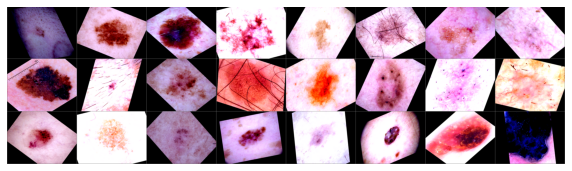

In [ ]:
# Function to Show Image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain Random Training Images
dataiter       = iter(train_data_loader)
images, labels = dataiter.next()

# Show the Images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Architecture

In [ ]:
dummy_net = torchvision.models.regnet_x_800mf(pretrained = True) 
print(dummy_net)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): ConvNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): ConvNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            (1): B

In [ ]:
# Alexnet Final Layers Sample - How to Play with them in the Necessary Structure
"""(classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)"""

'(classifier): Sequential(\n    (0): Dropout(p=0.5, inplace=False)\n    (1): Linear(in_features=9216, out_features=4096, bias=True)\n    (2): ReLU(inplace=True)\n    (3): Dropout(p=0.5, inplace=False)\n    (4): Linear(in_features=4096, out_features=4096, bias=True)\n    (5): ReLU(inplace=True)\n    (6): Linear(in_features=4096, out_features=1000, bias=True)'

In [ ]:
# The Choice of our Architecture to Train
model = "regnet_x_800mf"

# Replacing the Last Layer(s) of "x"net to Match our Number of Classes
net    = torchvision.models.regnet_y_800mf(pretrained = True)
net.fc = nn.Linear(784, num_classes)

print(net)
net = net.to(device)

# Number of Loops over the Dataset (try-cad2 have no architecture changes, hence the final models)
model_save_dir = main_dir + 'pytorch-multiclass-models/try-cad2-checkpoint-epoch{0}-batchsize{1}-{2}.pt'.format(num_epochs, num_size, str(model))
print(model_save_dir)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): ConvNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): ConvNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            (1): B

In [ ]:
"""# If the model is to be used as a Feature Extractor, setting its parameters to non-trainable (by default, trainable)
for param in model.parameters():
    param.requires_grad = False"""

## Functions for Metrics and Validation Evaluation

In [ ]:
def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item()
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

class EarlyStopping:
    """Early Stops the Training if the Validation Loss doesn't improve after a predefined Patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        
        self.patience     = patience
        self.verbose      = verbose
        self.counter      = 0
        self.best_score   = None
        self.early_stop   = False
        self.val_loss_min = np.Inf
        self.delta        = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation Loss Decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving Model ...')
        torch.save(model.state_dict(), model_save_dir)
        self.val_loss_min = val_loss

## Training Progress

In [ ]:
# Clearing the GPU Cache
torch.cuda.empty_cache()

In [ ]:
load_checkpoint  = False
print("Starting Training with Network: " + model + ", Loading Checkpoint Status : " + str(load_checkpoint))

# Optimizer and Loss Configurations
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) # weight=class_weights
optimizer = optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')

Starting Training with Network: regnet_x_800mf, Loading Checkpoint Status : False


In [ ]:
if load_checkpoint == False:
  #net.load_state_dict(torch.load('/content/drive/MyDrive/CAD/Project - 2/Challenge 2/pytorch-multiclass-models/checkpoint-epoch-{0}.pt'.format(num_epochs)))
  #print("Here")

  # Initializing the early_stopping
  early_stopping = EarlyStopping(patience=patience, verbose=True)

  accuracy      = []
  val_accuracy  = []
  losses        = []
  val_losses    = []
  best_accuracy = 0

  for epoch in range(num_epochs):
      running_loss      = 0.0
      correct_total     = 0.0
      num_samples_total = 0.0
      for i, data in enumerate(Bar(train_data_loader)):
          # Getting the Inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Setting the Parameter Gradients to Zero
          optimizer.zero_grad()

          # Forward Pass + Backward Pass + Optimize
          outputs = net(inputs)
          loss    = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          # Computing Accuracy
          _, predicted = torch.max(outputs, 1)
          b_len, corr = get_accuracy(predicted, labels)
          num_samples_total +=b_len
          correct_total +=corr
          running_loss += loss.item()

      running_loss /= len(train_data_loader)
      train_accuracy = correct_total/num_samples_total
      val_loss, val_acc = evaluate(net, validation_data_loader)
      scheduler.step(val_loss)
      
      print('Epoch: %d' %(epoch+1))
      print('Training Loss: %.3f , Training Accuracy:%.3f => Validation Loss: %.3f, Validation Accuracy: %.3f ' %(running_loss, train_accuracy,val_loss, val_acc))

      losses.append(running_loss)     # List Containing the Training Losses
      val_losses.append(val_loss)     # List Containing the Validation Losses
      accuracy.append(train_accuracy) # List Containing the Training Accuracy
      val_accuracy.append(val_acc)    # List Containing the Validation Accuracy        

      # early_stopping needs Validation Loss to check if it decreases and if so, it makes a Checkpoint of the Current Model
      early_stopping(val_loss, net)
      
      if early_stopping.early_stop:
          print('Early Stopping')
          break

  print('Finished Training')

2000/2000: [===============================>] - ETA 2.5s
Epoch: 1
Training Loss: 1.055 , Training Accuracy:0.393 => Validation Loss: 1.014, Validation Accuracy: 0.512 
Validation Loss Decreased (inf --> 1.014461).  Saving Model ...
2000/2000: [===============================>] - ETA 2.4s
Epoch: 2
Training Loss: 0.808 , Training Accuracy:0.612 => Validation Loss: 0.712, Validation Accuracy: 0.684 
Validation Loss Decreased (1.014461 --> 0.711941).  Saving Model ...
2000/2000: [===============================>] - ETA 2.4s
Epoch: 3
Training Loss: 0.613 , Training Accuracy:0.721 => Validation Loss: 0.592, Validation Accuracy: 0.756 
Validation Loss Decreased (0.711941 --> 0.591894).  Saving Model ...
2000/2000: [===============================>] - ETA 2.4s
Epoch: 4
Training Loss: 0.535 , Training Accuracy:0.742 => Validation Loss: 0.513, Validation Accuracy: 0.782 
Validation Loss Decreased (0.591894 --> 0.513097).  Saving Model ...
2000/2000: [===============================>] - ETA 2.4s


Training and Validation Accuracy Curve

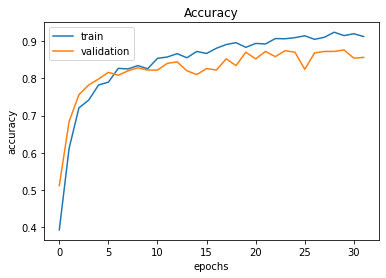

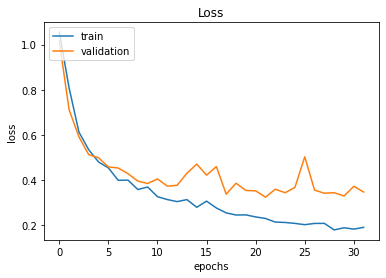

In [ ]:
#tmpdir = "/content/"
plt.figure()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig("{}/accuracy.png".format(tmpdir))

# Training and Validation Loss
plt.figure()
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig("{}/loss.png".format(tmpdir))

## Testing Accuracy and Confusion Matrix
Validation Accuracy and Confusion Matrix without Test Time Augmentation

In [ ]:
# Loading the best model
net.load_state_dict(torch.load(model_save_dir))

<All keys matched successfully>

In [ ]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/CAD/Project - 2/Challenge 2/pytorch-multiclass-models/checkpoint-epoch-{0}.pt'.format(num_epochs)))

correct = 0
total = 0
net.eval()

with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the Network on the Validation Images: %d %%' % (
    100 * correct / total))

Accuracy of the Network on the Validation Images: 87 %


In [ ]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix, "\n")
cm = confusion_matrix.numpy()

recall_bcc = cm[0][0]/np.sum(cm[:,0])
recall_bkl = cm[1][1]/np.sum(cm[:,1])
recall_mel = cm[2][2]/np.sum(cm[:,2])

precision_bcc = cm[0][0]/np.sum(cm[0])
precision_bkl = cm[1][1]/np.sum(cm[1])
precision_mel = cm[2][2]/np.sum(cm[2])

total = np.sum(cm)
print(total)
accuracy_bcc = cm[0][0] + (total - np.sum(cm[0]) - np.sum(cm[:,0]) + cm[0][0])
accuracy_bkl = cm[1][1] + (total - np.sum(cm[1]) - np.sum(cm[:,1]) + cm[1][1])
accuracy_mel = cm[2][2] + (total - np.sum(cm[2]) - np.sum(cm[:,2]) + cm[2][2])

print("bcc - recall : ",recall_bcc, " precision : ",precision_bcc, " accuracy : ",(accuracy_bcc/total))
print("bkl - recall : ",recall_bkl, " precision : ",precision_bkl, " accuracy : ",(accuracy_bkl/total))
print("mel - recall : ",recall_mel, " precision : ",precision_mel, " accuracy : ",(accuracy_mel/total))

tensor([[ 94.,   4.,   2.],
        [  9., 161.,  30.],
        [  4.,  15., 181.]]) 

500.0
bcc - recall :  0.8785047  precision :  0.94  accuracy :  0.962
bkl - recall :  0.89444447  precision :  0.805  accuracy :  0.884
mel - recall :  0.84976524  precision :  0.905  accuracy :  0.898


0.872


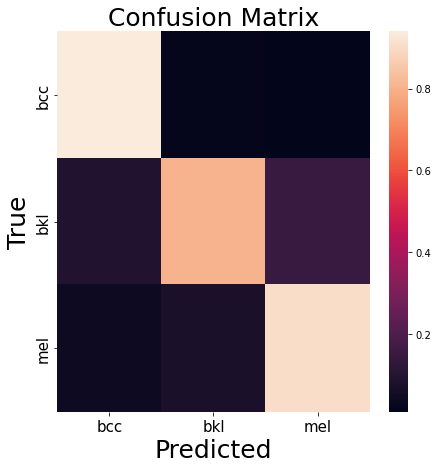

In [ ]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['bcc','bkl','mel'], size=15); 
ax.yaxis.set_ticklabels(['bcc','bkl','mel'], size=15);
print(correct/total)